In [ ]:
# sets *your* project id
PROJECT_ID = "PROJECT_ID" #@param {type:"string"}

In [ ]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_0_2' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

# **Obtain Authorization to access the database**



In [ ]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


# **Loading data using DataTable**


In [ ]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000

# **Creating a configuration query using "bigquery"**

In [ ]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config

## **Reading in admissions data**

In [ ]:
%%bigquery admissions
SELECT * FROM admissions

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
admissions.head(1000)

patientid  admissionid  admissioncount location  urgency  \
0          117          130               1       MC        0   
1          570          656               1       MC        0   
2          700          799               1       MC        0   
3          817          941               1       MC        0   
4          951         1098               1       MC        0   
..         ...          ...             ...      ...      ...   
995       1923         2211               1       IC        0   
996       1927         2215               1       IC        0   
997       1930         2218               1       IC        0   
998       1934         2223               1       IC        0   
999       1952         2242               1       IC        0   

                       origin  admittedat admissionyeargroup  dischargedat  \
0                        None           0          2003-2009      91560000   
1                        None           0          2003-2009      90780000   
2                        None           0          2003-2009     104460000   
3                        None           0          2003-2009      86580000   
4                        None           0          2003-2009      75000000   
..                        ...         ...                ...           ...   
995                      None           0          2010-2016      83940000   
996                      None           0          2003-2009     281400000   
997  CCU/IC zelfde ziekenhuis           0          2010-2016      88500000   
998                      None           0          2003-2009      70200000   
999                      None           0          2003-2009      87600000   

     lengthofstay destination gender agegroup   dateofdeath weightgroup  \
0              26        None    Man    70-79          <NA>       70-79   
1              25        None    Man    70-79  229442400000       60-69   
2              29        None    Man    60-69          <NA>       70-79   
3              24        None    Man    70-79  162649800000       60-69   
4              20        None           70-79          <NA>       60-69   
..            ...         ...    ...      ...           ...         ...   
995            23          15  Vrouw    70-79   34519620000       70-79   
996            78          15  Vrouw    60-69          <NA>       90-99   
997            24          15    Man    60-69          <NA>       90-99   
998            19          15    Man    60-69          <NA>       70-79   
999            25          15           60-69  146149440000       90-99   

    weightsource heightgroup heightsource        specialty  
0           None     180-189         None             None  
1           None     160-169         None             None  
2           None     170-179         None             None  
3           None     160-169         None             None  
4           None     170-179         None             None  
..           ...         ...          ...              ...  
995         None     170-179         None  Cardiochirurgie  
996         None     160-169         None  Cardiochirurgie  
997         None     160-169         None  Cardiochirurgie  
998         None     170-179         None  Cardiochirurgie  
999         None     180-189         None  Cardiochirurgie  

[1000 rows x 19 columns]

**Using Python pandas to manipulate the tables**

In [ ]:
import pandas as pd

config_gbq = {'query':
          {'defaultDataset': {
              "datasetId": DATASET_ID,
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

In [ ]:
admissions['urgency'].value_counts()

0    16860
1     6246
Name: urgency, dtype: Int64

# **Overview of database**



*   ## This database contains data for the period 01/01/2003 - 31/12/2016.
*   ## Number of total admissions:23016
        Number of Planned admissions:16860
        Number of Emergency admissions:6246  
*   ## In this period, there are 5114 days; 3556 days are weekdays and 1461 days are weekends. There are 142 holidays, 45 days of them are the weekends. Therefore, we have 3556 working days and 1558 non-working days.

*  ## This period contains 730 weeks and 4 days.








In [ ]:
# Calculate the admission rates
avg_emergency_admission = round(6246/5114,2)
avg_planned_admission = round(16860/3653,2)

### **Creating a smaller table which includes data for "length of stays" and "urgency level" of each admission**

In [ ]:
df_admission = admissions[['patientid','admissionid','lengthofstay']].copy()

In [ ]:
df_admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23106 entries, 0 to 23105
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   patientid     23106 non-null  Int64
 1   admissionid   23106 non-null  Int64
 2   lengthofstay  23106 non-null  Int64
dtypes: Int64(3)
memory usage: 609.4 KB


### **Calculating "Number of Admissions" for each "Length of stays" for all admissions.**

In [ ]:
for value in df_admission['lengthofstay'].values:
  df_admission.loc[df_admission['lengthofstay'] == value, 'probability']= df_admission['lengthofstay'].value_counts(normalize = True).at[value]

df_admission


patientid  admissionid  lengthofstay  probability
0            117          130            26     0.015321
1            570          656            25     0.028045
2            700          799            29     0.005496
3            817          941            24     0.053017
4            951         1098            20     0.044923
...          ...          ...           ...          ...
23101      20155        23348            65     0.002900
23102      20229        23437            84     0.001601
23103      20246        23459            62     0.002727
23104      20266        23483            26     0.015321
23105      20268        23485            88     0.001731

[23106 rows x 4 columns]

### **Calculating "Number of Emergency Admissions" for each "Length of stays" for all admissions.**

In [ ]:
df_admission_emergency = df_admission.drop(columns=['probability'])

df_admission_emergency = df_admission_emergency.loc[df_admission['urgency']==1]
df_admission_emergency

### **Recalculating the probability of occurrence of a "Length of Stay" for emergency admissions**

In [ ]:
for value in df_admission_emergency['lengthofstay'].values:
  df_admission_emergency.loc[df_admission_emergency['lengthofstay'] == value, 'number_of_admissions']= df_admission_emergency['lengthofstay'].value_counts().at[value]
  df_admission_emergency.loc[df_admission_emergency['lengthofstay'] == value, 'probability']= df_admission_emergency['lengthofstay'].value_counts(normalize = True).at[value]

df_admission_emergency.sort_values('lengthofstay')

### **A plot showing the distribution of emergency admissions based on their length of stays.**




<BarContainer object of 6051 artists>

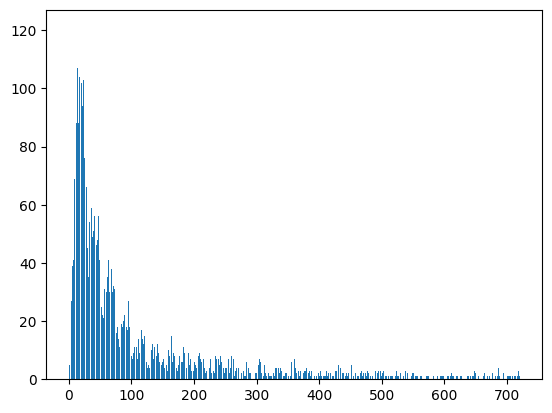

In [ ]:
from matplotlib import pyplot as plt
df_admission_emergency_short = df_admission_emergency[df_admission_emergency['lengthofstay']<=720]
plt.bar(df_admission_emergency_short['lengthofstay'],df_admission_emergency_short['number_of_admissions'])

<BarContainer object of 5586 artists>

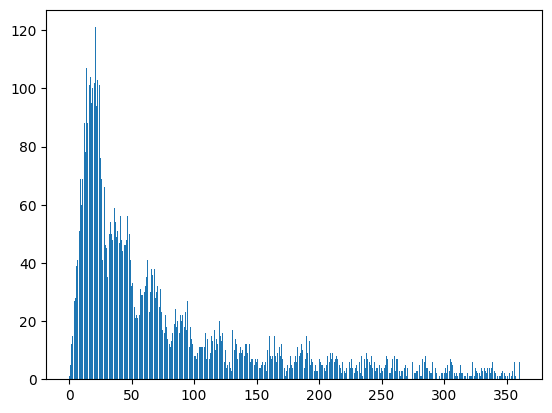

In [ ]:
from matplotlib import pyplot as plt
df_admission_emergency_veryshort = df_admission_emergency[df_admission_emergency['lengthofstay']<=360]
plt.bar(df_admission_emergency_veryshort['lengthofstay'],df_admission_emergency_veryshort['number_of_admissions'])

### **Calculating "Number of Planned Admissions" and their probability of occurrence for each "Length of Stays" for all admissions.**

In [ ]:
df_admission_planned = df_admission.drop(columns=['probability'])
df_admission_planned = df_admission_planned.loc[df_admission['urgency']==0]
for value in df_admission_planned['lengthofstay'].values:
  df_admission_planned.loc[df_admission_planned['lengthofstay'] == value, 'number_of_admissions']= df_admission_planned['lengthofstay'].value_counts().at[value]
  df_admission_planned.loc[df_admission_planned['lengthofstay'] == value, 'probability']= df_admission_planned['lengthofstay'].value_counts(normalize = True).at[value]

df_admission_planned.sort_values('lengthofstay')

### **A plot showing the distribution of planned admissions based on their length of stays.**

<BarContainer object of 15718 artists>

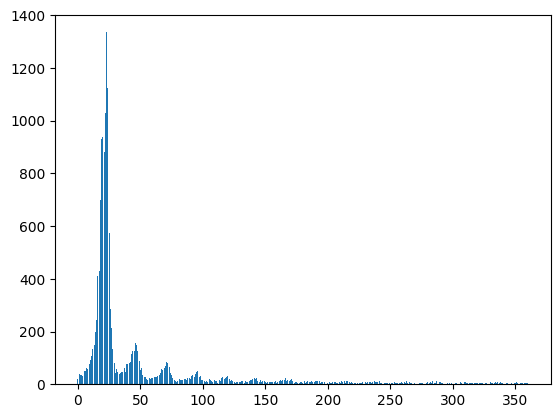

In [ ]:
from matplotlib import pyplot as plt
df_admission_planned_veryshort = df_admission_planned[df_admission_planned['lengthofstay']<=360]
plt.bar(df_admission_planned_veryshort['lengthofstay'],df_admission_planned_veryshort['number_of_admissions'])

# **To run the simulation for one time and to see the relevant data and plots, run the following blocks. If you want to run the simulation more than once go to the next block.**


## **Description of Simulation**
I have written the simulation code using SimPy simulation framework of Python. It runs for 365 days. The ICU bed occupancy gets updated at the end of each days. This simulation has a two-fold application. It can predict the bed occupancy in a normal condition based on data provided by Amsterdam UMC database . Moreover, based on the extracted data from the database for all patients with ARDS a pandemic-like simulation is also executed. Both situations are within the same code; to achieve either a normal or a pandemic-like situation, one can change the values of the relevant variables in  the code.

In [ ]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# In order to run the simulation for one time and to see the relevant data and plots, run the following blocks. If you want to run the simulation for many times go to the next block.

In [ ]:
from pickle import FALSE
import random
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


## **Simulating ICU admissions at a given day**


---



### **Calculating ICU admisssion rate for the simulation**


We use three different approaches to do so:

1.   Using a Log-Normal Distribution with the mean ($\mu$ parameter) of logarithm of distribution obtained from the real data, $\mu = \log{(\textrm{average admissions})}$
2.   Using a Poisson Distribution with the mean of length of stay obtained from the real data, based on Amesterdam UCM database $\textrm{mean} = 22$ (see above plots).
3.   Random choice of lengths of stays wighted using the probability of Planned, Emergency or Pandemic ARDS distribution calculated above.


**Note 1: In this simulation, we have considered that Planned admissions only occur on weekdays while Emergency admissions happen every day.**

**Note 2: We have assumed a $\mu$ parameter for the pandemic simulation as $ \mu_{\textrm{Pandemic}} = 2(\mu_{\textrm{Planned}} + \mu_{\textrm{Emergency}})$.**



In [ ]:
# Calculate the admission rates

avg_emergency_admission = 6246/5114
avg_planned_admission = 16860/3653
emergency_mu_parameter = np.log(avg_emergency_admission)
planned_mu_parameter = np.log(avg_planned_admission)


# Define the number of ICU beds
icu_beds = 20

# Initialize the extra_beds_needed variable
extra_beds_needed = 1


In [ ]:
# Function to simulate ICU admissions for a given day
def simulate_admissions(env, real_data, use_poisson_distribution, mean_length_of_stay):
    # Get the current date and check if it's a weekday or weekend
    current_date = datetime.fromtimestamp(env.now)  # Convert days to seconds
    is_weekday = current_date.weekday() < 5  # Monday = 0, ..., Friday = 4


    # Define the planned admission rate (number of planned admissions per weekday)
    planned_admission_rate = round(np.random.lognormal(planned_mu_parameter,sigma=0.5))

    # Define the number of emergency admissions per day (can vary)
    emergency_admission_rate = round(np.random.lognormal(emergency_mu_parameter,sigma=0.5))

    # Calculate the total admission rate based on the type of admission
    if is_weekday:
        total_admission_rate = planned_admission_rate + emergency_admission_rate
    else:
        total_admission_rate = emergency_admission_rate

    # Simulate ICU admissions for the day
    if use_poisson_distribution:
        admissions = np.random.poisson(mean_length_of_stay, total_admission_rate)
        print(f"admission was selected from a random Poisson distribution with mean ={mean_length_of_stay}")
    else:
        admissions = np.random.choice(length_of_stay_distribution, size = total_admission_rate, p=probability_length_of_stay_data_array)

    admission_priority = [0] * planned_admission_rate + [1] * (total_admission_rate - planned_admission_rate)

    return admissions, admission_priority, total_admission_rate

### **This Function updates the ICU bed occupancy at the end of each day of simulation by taking into account the discharged patients on each day of simulation**

In [ ]:
# Function to update occupancy and occupied beds
def update_occupancy(admissions, icu_beds_capacity, occupied_beds):
    # Extend occupied_beds by admissions
    occupied_beds.extend(admissions)
    beginning_of_day_occupancy = len(occupied_beds)

    # Check if the size of ocupied_beds is smaller than the number of icu_beds
 #   if len(occupied_beds) < icu_beds_capacity.capacity:
        # Change occupied_beds to a list only containing values bigger than 24
        # and subtract 24 from the remaining values
    occupied_beds = [(val - 24) for val in occupied_beds if val > 24]

    end_of_day_occupancy = len(occupied_beds)
    discharged = beginning_of_day_occupancy - end_of_day_occupancy
    occupancy = beginning_of_day_occupancy - discharged



    return beginning_of_day_occupancy, occupancy, occupied_beds



## **Function to define the Simulation Process**

In [ ]:
# Simulation process
def simulate_icu_occupancy(env, icu_beds_capacity, extra_beds_needed, mean_length_of_stay):
    occupancy = 0
    occupied_beds = []
    bed_capacity_reached = False

    half_time = 365 / 2

    while True:
        admissions, admission_priority, total_admission_rate = simulate_admissions(env, real_data, use_poisson_distribution, mean_length_of_stay)

        with icu_beds_capacity.request(priority=max(admission_priority)) as request:
            yield request

            beginning_of_day_occupancy, occupancy, occupied_beds = update_occupancy(admissions, icu_beds_capacity, occupied_beds)

            # Append data to occupancy and bed capacity lists
            occupancy_BOD_data.append(beginning_of_day_occupancy)
            occupancy_EOD_data.append(occupancy)
            bed_capacity_data.append(icu_beds_capacity.capacity)
            admission_rate_data.append(total_admission_rate)
            emergency_rate_data.append(admission_priority.count(1))
            planned_rate_data.append(admission_priority.count(0))


            #print(f'On day {env.now}')
            #print(f"admissions: {admissions}")
            #print(f"maximum number of occupied bed: {beginning_of_day_occupancy}")
            #print(f"Occupancy: {occupancy}")
            #print(f"Occupied beds: {occupied_beds}")
            #print(f"total_admission_rate: {total_admission_rate}")
            #if occupancy >= icu_beds_capacity.capacity:
            #   if not bed_capacity_reached:
            #       bed_capacity_reached = True
            #       if env.now <= half_time:
            #           print(f"Bed capacity reached at {env.now} days. Simulation restarted with one extra bed.")
            #           with extra_beds_needed.request() as extra_bed_request:
            #               yield extra_bed_request
            #           new_capacity = icu_beds_capacity.capacity + 1
            #           icu_beds_capacity = simpy.PriorityResource(env, capacity=new_capacity)
            #           occupancy = 0
            #           occupied_beds = []
            #           bed_capacity_reached = False




        yield env.timeout(1)

## **Deciding that which of the calculations for admission rate we use and calculate the relevant data to compute the corresponding distributions**

In [ ]:
# Define the length of stay distribution

use_poisson_distribution = False
real_data = True
mean_length_of_stay = 22

if use_poisson_distribution:
    mean_length_of_stay = 22  # Mean length of stay for Poisson distribution

elif real_data :     # Set to True if using real data

    length_of_stay_data = df_admission['lengthofstay']  # Assuming 'lengthofstay' is the column name in the DataFrame
    probability_length_of_stay_data = df_admission['probability']

    length_of_stay_data_array = length_of_stay_data.values
    probability_length_of_stay_data_array = probability_length_of_stay_data.values

    # Normalize the probabilities
    probability_length_of_stay_data_array /= np.sum(probability_length_of_stay_data_array)


    length_of_stay_distribution = length_of_stay_data_array
    print(f"Admissions were selected from a choice of real data based on a log-normal distributaion with sigma = 0.5 and mu = ({planned_mu_parameter},{emergency_mu_parameter}) for planned and emergency admissions respectively.")
else:
    length_of_stay_distribution = np.random.randint(0, 50, size=(1, 10))
    print(f"Admissions was selected from a random selection of random integer numbers")



Admissions were selected from a choice of real data based on a log-normal distributaion with sigma = 0.5 and mu = (1.529395204760564,0.19995938199189203) for planned and emergency admissions respectively.


## **Initializing empty lists to store data for bed occupancy and admission rates on each day of simulation**

In [ ]:
# Create lists to store occupancy and bed capacity data
occupancy_BOD_data = []
occupancy_EOD_data = []
bed_capacity_data = []
admission_rate_data = []
emergency_rate_data = []
planned_rate_data = []


## **Setting the Simulation environment and ruuning it for 365 days of simulation**

In [ ]:
# Run the simulation
env = simpy.Environment()
icu_beds_capacity = simpy.PriorityResource(env, capacity=icu_beds)
extra_beds_needed = simpy.Resource(env, capacity=extra_beds_needed)
simulation = env.process(simulate_icu_occupancy(env, icu_beds_capacity, extra_beds_needed,  mean_length_of_stay))
env.run(until=365)


## **Making a table of collected data from simulation and Plotting them**

In [ ]:
# Print the simulation results

# Create a pandas DataFrame
data = {'Admission rate': admission_rate_data, 'Planned admissions': planned_rate_data, 'Emergency admissions': emergency_rate_data, 'Beds occupied during the day': occupancy_BOD_data, 'Occupancy at the end of day': occupancy_EOD_data, 'Bed Capacity': bed_capacity_data}
df_data = pd.DataFrame(data)

# Print the DataFrame
df_data


Admission rate  Planned admissions  Emergency admissions  \
0                 8                   7                     1   
1                 8                   7                     1   
2                10                   9                     1   
3                 7                   4                     3   
4                16                  15                     1   
..              ...                 ...                   ...   
360               4                   3                     1   
361               6                   5                     1   
362               6                   5                     1   
363               8                   7                     1   
364               4                   3                     1   

     Beds occupied during the day  Occupancy at the end of day  Bed Capacity  
0                               8                            1            20  
1                               9                            2            20  
2                              12                            4            20  
3                              11                            2            20  
4                              18                            2            20  
..                            ...                          ...           ...  
360                             5                            1            20  
361                             7                            2            20  
362                             8                            0            20  
363                             8                            0            20  
364                             4                            0            20  

[365 rows x 6 columns]

**Description of Plot:**

* Blue plot is depicting the number of occupied beds at the end of each day of simulation

* Orange plot is depicting the maximum number of occupied beds at each day of simulation

**Note: At the beginning of each day of simulation all admitted patients are counted. Due to the removal of time stamp from data for anonymization purposes, we could not input admission data in an hourly base.**

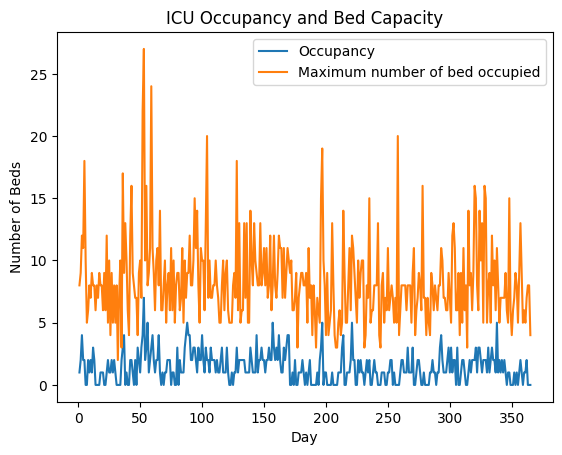

In [ ]:
# Plot the occupancy and bed capacity data
days = np.arange(1, len(occupancy_EOD_data) + 1)

plt.plot(days, occupancy_EOD_data, label='Occupancy')
plt.plot(days, occupancy_BOD_data, label='Maximum number of bed occupied')
plt.xlabel('Day')
plt.ylabel('Number of Beds')
plt.title('ICU Occupancy and Bed Capacity')
plt.legend()
plt.show()

In [ ]:
df_data['Beds occupied during the day'].nlargest(10)

52     27
58     24
51     22
103    20
257    20
196    19
4      18
127    18
35     17
42     16
Name: Beds occupied during the day, dtype: int64

In [ ]:
df_data['Beds occupied during the day'].max()

27

# **To have a better grasp at the statiscs behind the simulation, we create an ensemble of simulations.**

## **To run the simulation for 10000 times and compre the maximum number of occupancy run the following block.**

In [ ]:
from pickle import FALSE
import random
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta






# Calculate the admission rates
#avg_emergency_admission = round(6246/5114,2)
#avg_planned_admission = round(16860/3653,2)
avg_emergency_admission = 6246/5114
avg_planned_admission = 16860/3653
emergency_mu_parameter = np.log(avg_emergency_admission)
planned_mu_parameter = np.log(avg_planned_admission)



# Define the number of ICU beds
icu_beds = 20

# Initialize the extra_beds_needed variable
extra_beds_capacity = 1

# Create lists to store occupancy and bed capacity data for each run
all_occupancy_BOD_data = []
all_occupancy_EOD_data = []
all_bed_capacity_data = []
all_admission_rate_data = []
all_emergency_rate_data = []
all_planned_rate_data = []


# Function to simulate ICU admissions for a given day
def simulate_admissions(env, real_data, use_poisson_distribution, mean_length_of_stay):
    # Get the current date and check if it's a weekday or weekend
    current_date = datetime.fromtimestamp(env.now)  # Convert days to seconds
    is_weekday = current_date.weekday() < 5  # Monday = 0, ..., Friday = 4


    # Define the planned admission rate (number of planned admissions per weekday)
    planned_admission_rate = round(np.random.lognormal(planned_mu_parameter,sigma=0.5))

    # Define the number of emergency admissions per day (can vary)
    emergency_admission_rate = round(np.random.lognormal(emergency_mu_parameter,sigma=0.5))

    # Calculate the total admission rate based on the type of admission
    if is_weekday:
        total_admission_rate = planned_admission_rate + emergency_admission_rate
    else:
        total_admission_rate = emergency_admission_rate

    # Simulate ICU admissions for the day
    if use_poisson_distribution:
        admissions = np.random.poisson(mean_length_of_stay, total_admission_rate)
        print(f"admission was selected from a random Poisson distribution with mean ={mean_length_of_stay}")
    else:
        admissions = np.random.choice(length_of_stay_distribution, size = total_admission_rate, p=probability_length_of_stay_data_array)

    admission_priority = [0] * planned_admission_rate + [1] * (total_admission_rate - planned_admission_rate)

    return admissions, admission_priority, total_admission_rate


# Function to update occupancy and occupied beds
def update_occupancy(admissions, icu_beds_capacity, occupied_beds):
    # Extend occupied_beds by admissions
    occupied_beds.extend(admissions)
    beginning_of_day_occupancy = len(occupied_beds)

    # Check if the size of ocupied_beds is smaller than the number of icu_beds
 #   if len(occupied_beds) < icu_beds_capacity.capacity:
        # Change occupied_beds to a list only containing values bigger than 24
        # and subtract 24 from the remaining values
    occupied_beds = [(val - 24) for val in occupied_beds if val > 24]

    end_of_day_occupancy = len(occupied_beds)
    discharged = beginning_of_day_occupancy - end_of_day_occupancy
    occupancy = beginning_of_day_occupancy - discharged



    return beginning_of_day_occupancy, occupancy, occupied_beds



# Simulation process
def simulate_icu_occupancy(env, icu_beds_capacity, extra_beds_needed, mean_length_of_stay):
    occupancy = 0
    occupied_beds = []
    bed_capacity_reached = False

    half_time = 365 / 2

    while True:
        admissions, admission_priority, total_admission_rate = simulate_admissions(env, real_data, use_poisson_distribution, mean_length_of_stay)

        with icu_beds_capacity.request(priority=max(admission_priority)) as request:
            yield request

            beginning_of_day_occupancy, occupancy, occupied_beds = update_occupancy(admissions, icu_beds_capacity, occupied_beds)

            # Append data to occupancy and bed capacity lists
            occupancy_BOD_data.append(beginning_of_day_occupancy)
            occupancy_EOD_data.append(occupancy)
            bed_capacity_data.append(icu_beds_capacity.capacity)
            admission_rate_data.append(total_admission_rate)
            emergency_rate_data.append(admission_priority.count(1))
            planned_rate_data.append(admission_priority.count(0))


            #print(f'On day {env.now}')
            #print(f"admissions: {admissions}")
            #print(f"maximum number of occupied bed: {beginning_of_day_occupancy}")
            #print(f"Occupancy: {occupancy}")
            #print(f"Occupied beds: {occupied_beds}")
            #print(f"total_admission_rate: {total_admission_rate}")
            #if occupancy >= icu_beds_capacity.capacity:
            #   if not bed_capacity_reached:
            #       bed_capacity_reached = True
            #       if env.now <= half_time:
            #           print(f"Bed capacity reached at {env.now} days. Simulation restarted with one extra bed.")
            #           with extra_beds_needed.request() as extra_bed_request:
            #               yield extra_bed_request
            #           new_capacity = icu_beds_capacity.capacity + 1
            #           icu_beds_capacity = simpy.PriorityResource(env, capacity=new_capacity)
            #           occupancy = 0
            #           occupied_beds = []
            #           bed_capacity_reached = False




        yield env.timeout(1)

# Define the length of stay distribution

use_poisson_distribution = False
real_data = True
mean_length_of_stay = 22

if use_poisson_distribution:
    mean_length_of_stay = 22  # Mean length of stay for Poisson distribution

elif real_data :     # Set to True if using real data

    length_of_stay_data = df_admission['lengthofstay']  # Assuming 'lengthofstay' is the column name in the DataFrame
    probability_length_of_stay_data = df_admission['probability']

    length_of_stay_data_array = length_of_stay_data.values
    probability_length_of_stay_data_array = probability_length_of_stay_data.values

    # Normalize the probabilities
    probability_length_of_stay_data_array /= np.sum(probability_length_of_stay_data_array)


    length_of_stay_distribution = length_of_stay_data_array
    print(f"Admissions were selected from a choice of real data based on a log-normal distributaion with sigma = 0.5 and mu = ({planned_mu_parameter},{emergency_mu_parameter}) for planned and emergency admissions respectively.")
else:
    length_of_stay_distribution = np.random.randint(0, 50, size=(1, 10))
    print(f"Admissions was selected from a random selection of random integer numbers")

# Set the number of simulations
num_simulations = 10000

# Run the simulations
for i in range(num_simulations):
    # Create a new environment for each simulation
    env = simpy.Environment()
    icu_beds_capacity = simpy.PriorityResource(env, capacity=icu_beds)
    extra_beds_needed = simpy.Resource(env, capacity=extra_beds_capacity)

    # Reset the data lists for each simulation
    occupancy_BOD_data = []
    occupancy_EOD_data = []
    bed_capacity_data = []
    admission_rate_data = []
    emergency_rate_data = []
    planned_rate_data = []

    # Run the simulation
    simulation = env.process(simulate_icu_occupancy(env, icu_beds_capacity, extra_beds_needed, mean_length_of_stay))
    env.run(until=365)

    # Append the data of each simulation to the all_* data lists
    all_occupancy_BOD_data.append(occupancy_BOD_data)
    all_occupancy_EOD_data.append(occupancy_EOD_data)
    all_bed_capacity_data.append(bed_capacity_data)
    all_admission_rate_data.append(admission_rate_data)
    all_emergency_rate_data.append(emergency_rate_data)
    all_planned_rate_data.append(planned_rate_data)

# Create a pandas DataFrame for each simulation
all_dataframes = []
for i in range(num_simulations):
    data = {
        'Admission rate': all_admission_rate_data[i],
        'Planned admissions': all_planned_rate_data[i],
        'Emergency admissions': all_emergency_rate_data[i],
        'Beds occupied during the day': all_occupancy_BOD_data[i],
        'Occupancy at the end of day': all_occupancy_EOD_data[i],
        'Bed Capacity': all_bed_capacity_data[i]
    }
    df = pd.DataFrame(data)
    all_dataframes.append(df)

# Print the DataFrame for each simulation
#for i in range(num_simulations):
#   print(f"Simulation {i+1}:")
#   print(all_dataframes[i])
#   print()

# Calculate and return the maximum occupancy
max_occupancy =[]
for i in range(num_simulations):
    max_occupancy.append(all_dataframes[i]['Beds occupied during the day'].max())

#print(f'max_occupancy:{max_occupancy}')


Admissions were selected from a choice of real data based on a log-normal distributaion with sigma = 0.5 and mu = (1.529395204760564,0.19995938199189203) for planned and emergency admissions respectively.


### **This plot shows the maximum occupancy of ICU beds that occurred on each simulation for 10000 simulations runs.**

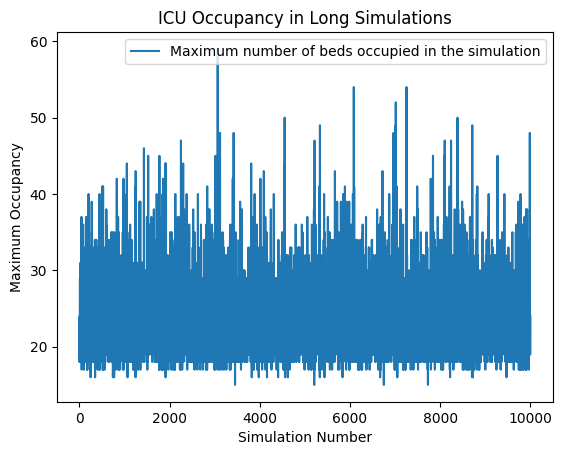

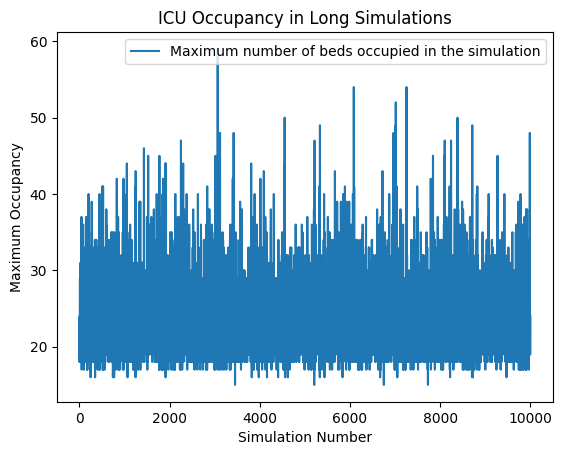

In [ ]:
# Plot the maximum occupancy during simulations
number_of_simulations = np.arange(1, num_simulations+1)

plt.plot(number_of_simulations, max_occupancy, label='Maximum number of beds occupied in the simulation')
plt.xlabel('Simulation Number')
plt.ylabel('Maximum Occupancy')
plt.title('ICU Occupancy in Long Simulations')
plt.legend()
plt.show()

In [ ]:
max(max_occupancy)

59

In [ ]:
min(max_occupancy)

15

## **Statistical Analysis of the Result of Ensemble of Simulations**

In [ ]:
import statistics
from statistics import mean
mean(max_occupancy)

23

In [ ]:
max_array_10000 = np.asarray(max_occupancy)
new_dataframe_10000 = pd.DataFrame({'Max_Occupancy': max_array_10000})
new_dataframe_10000.describe()

Max_Occupancy
count   10000.000000
mean       23.418900
std         4.253332
min        15.000000
25%        21.000000
50%        23.000000
75%        25.000000
max        59.000000

In [ ]:
new_dataframe_10000.loc[new_dataframe_10000['Max_Occupancy']>= 1.65 * mean(max_occupancy)]

Max_Occupancy
202              40
272              39
436              39
443              40
508              41
...             ...
9735             39
9782             40
9903             38
9928             38
9987             48

[109 rows x 1 columns]

In [ ]:
1.26 * mean(max_occupancy)

28.98

In [ ]:
2.1 * mean(max_occupancy)

48.300000000000004

In [ ]:
1.65 * mean(max_occupancy)

37.949999999999996

In [ ]:
new_dataframe_10000.loc[new_dataframe_10000['Max_Occupancy']>= 1.26 * mean(max_occupancy)]

Max_Occupancy
11               29
15               30
22               31
42               29
45               37
...             ...
9952             31
9967             34
9972             29
9984             30
9987             48

[1062 rows x 1 columns]